In [1]:
# 1

# Setup
# -*- coding: utf-8 -*-
%matplotlib inline

from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as p
import scipy as sp
from sklearn import datasets, linear_model, preprocessing
from sklearn import metrics, neighbors
import sklearn

In [5]:
# 2

# STORE ALL REFORMATTED BATTING DATA AND PITHING DATA W/ SALARIES IN CSV

years = ['2002', '2003', '2004', '2005', '2006', 
         '2007', '2008', '2009', '2010', '2011', 
         '2012', '2013', '2014', '2015', '2016', '2017']

teams = ['ARI','ATL','BAL','BOS','CHC','CHW','CIN','CLE','COL','DET','HOU',
         'KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI','PIT',
         'SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN']

luxury_tax_mult = [1.7, 1.66, 1.62, 1.52, 1.43, 
                   1.32,1.26, 1.2, 1.15, 1.1, 
                   1.1, 1.1, 1.03,1.03, 1.03, 1]

batting_train = p.DataFrame()
pitching_train = p.DataFrame() 
batting_test = p.DataFrame()
pitching_test = p.DataFrame()

for idx, year in enumerate(years):
    # Batting salary data for a year -->
    batting_df = p.read_csv('BattingSalary'+year+'.csv', 
                             engine='python')
    pitching_df = p.read_csv('PitchingSalary'+year+'.csv', 
                             engine='python') 
    
    batting_df['Tm'] = batting_df['Tm'].str.replace('ANA', 'LAA')
    batting_df['Tm'] = batting_df['Tm'].str.replace('MON', 'WSN')
    batting_df['Tm'] = batting_df['Tm'].str.replace('TBD', 'TBR')
    batting_df['Tm'] = batting_df['Tm'].str.replace('FLA', 'MIA')

    pitching_df['Tm'] = pitching_df['Tm'].str.replace('ANA', 'LAA')
    pitching_df['Tm'] = pitching_df['Tm'].str.replace('MON', 'WSN')
    pitching_df['Tm'] = pitching_df['Tm'].str.replace('TBD', 'TBR')
    pitching_df['Tm'] = pitching_df['Tm'].str.replace('FLA', 'MIA')    
    
    batting_df.columns = batting_df.columns.str.replace('Salary▼', 'Salary')
    pitching_df.columns = pitching_df.columns.str.replace('Salary▼', 'Salary')
    
    batting_df['Salary'] = batting_df['Salary'].str.replace('$','')
    pitching_df['Salary'] = pitching_df['Salary'].str.replace('$','')
 
    batting_df['Salary'] = batting_df['Salary'].astype(float)
    pitching_df['Salary'] = pitching_df['Salary'].astype(float)
    
    lux = luxury_tax_mult[idx]
    batting_df['Salary'] *= lux
    pitching_df['Salary'] *= lux
    
    if year == years[0]:
        batting_train = batting_df
        pitching_train = pitching_df
    else:
        batting_train = p.concat([batting_train, batting_df])
        pitching_train = p.concat([pitching_train, pitching_df])

    batting_df.to_csv('BattingStats'+year+'.csv', index=False)
    pitching_df.to_csv('PitchingStats'+year+'.csv', index=False)
        
batting_train.drop(batting_train.columns[[0, 1, -2]], axis=1, inplace=True)
batting_train = batting_train.fillna(0)

pitching_train.drop(pitching_train.columns[[0,1,-1]], axis=1, inplace=True)
pitching_train = pitching_train.fillna(0)

batting_train.to_csv('AllBattingData.csv', index=False)
pitching_train.to_csv('AllPitchingData.csv', index=False)

In [52]:
# 3

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# FORMAT TRAINING DATA FOR BATTING AND PITCHING
batting_train = p.read_csv('AllBattingData.csv')
pitching_train = p.read_csv('AllPitchingData.csv')

# Now remove team for the training data
batting_train.drop(batting_train.columns[[1]], axis=1, inplace=True)
pitching_train.drop(pitching_train.columns[[1]], axis=1, inplace=True)

batting_x = batting_train.drop(['Pos Summary'], axis=1)
batting_x = batting_x[(batting_x['G'] > 100)]
batting_x = batting_x[(batting_x['PA'] > 100)]
batting_y = batting_x[['Salary']]
batting_x = batting_x.drop(['Salary'], axis=1)
display(batting_x)

pitching_x = pitching_train[(pitching_train['G'] > 20)]
pitching_y = pitching_x[['Salary']]
pitching_x = pitching_x.drop(['Salary'], axis=1) 
display(pitching_x)

batting_train_x, batting_test_x, batting_train_y, batting_test_y = train_test_split(batting_x, batting_y, test_size=0.3, random_state=0)
pitching_train_x, pitching_test_x, pitching_train_y, pitching_test_y = train_test_split(pitching_x, pitching_y, test_size=0.3, random_state=0)

# CHECK PREDICT SALARIES BASED OFF OF STATISTICS
batting_regr = linear_model.LinearRegression()
scores = cross_val_score(batting_regr, batting_train_x.values, batting_train_y.values, cv=10)
batting_regr.fit(batting_train_x, batting_train_y)

pitching_regr = linear_model.LinearRegression()
scores = cross_val_score(pitching_regr, pitching_train_x.values, pitching_train_y.values, cv=10)

,Age,G,PA,Rbat,Rbaser,Rdp,Rfield,Rpos,RAA,WAA,Rrep,RAR,WAR,waaWL%,162WL%,oWAR,dWAR,oRAR
0,26,162,725.0,52,5,-1,1,9.0,65.0,6.4,26.0,91.0,8.8,0.539,0.539,8.7,1.0,90.0
1,30,143,628.0,32,-2,0,4,-8.0,27.0,2.7,23.0,50.0,4.9,0.519,0.516,4.5,-0.4,46.0
3,30,120,518.0,53,-1,-2,1,-8.0,43.0,4.2,19.0,63.0,6.0,0.535,0.526,6.0,-0.7,62.0
4,37,143,612.0,109,-2,0,0,-6.0,102.0,9.9,19.0,121.0,11.8,0.570,0.562,11.8,-0.7,121.0
5,33,150,666.0,53,0,-1,-8,-6.0,38.0,3.7,20.0,58.0,5.7,0.526,0.524,6.6,-1.6,66.0
6,28,157,730.0,15,8,0,-18,8.0,13.0,1.3,25.0,38.0,3.7,0.508,0.508,5.5,-0.9,57.0
8,29,158,685.0,44,-1,-2,13,-7.0,48.0,4.8,21.0,69.0,6.9,0.531,0.530,5.5,0.6,55.0
11,35,136,553.0,38,2,0,9,-6.0,43.0,4.4,17.0,61.0,6.1,0.533,0.528,5.2,0.2,52.0
12,33,154,699.0,38,2,1,-22,2.0,22.0,2.2,25.0,47.0,4.5,0.514,0.513,6.7,-1.8,69.0
13,34,139,558.0,8,-3,-1,-16,-7.0,-20.0,-2.2,17.0,-3.0,-0.5,0.485,0.487,1.2,-2.5,14.0


,Age,IP,G,GS,R,RA9,RA9opp,RA9def,RA9role,PPFp,RA9avg,RAA,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%
1,30,199.1,30,30,62,2.80,4.84,0.32,0.18,101.2,4.76,42.0,4.6,0.00,-0.1,6.5,66.0,0.653,0.528
2,38,260.0,35,35,78,2.70,4.55,-0.02,0.18,112.2,5.32,75.0,8.9,0.00,-0.2,10.9,98.0,0.753,0.555
3,36,199.1,34,34,67,3.03,4.50,0.50,0.17,100.9,4.21,25.0,2.8,0.00,-0.1,4.4,43.0,0.582,0.517
4,33,215.2,33,33,103,4.30,4.86,-0.33,0.18,99.1,5.32,23.0,2.4,0.00,-0.1,4.5,49.0,0.574,0.515
5,39,180.0,29,29,94,4.70,4.73,-0.31,0.17,99.2,5.17,9.0,0.9,0.00,-0.1,2.6,30.0,0.530,0.505
6,35,259.1,36,35,95,3.30,4.54,-0.02,0.17,112.7,5.34,58.0,6.7,0.04,-0.2,8.7,81.0,0.686,0.541
7,29,178.2,30,30,135,6.80,4.68,0.24,0.18,109.4,5.06,-35.0,-3.3,0.00,-0.1,-1.9,-20.0,0.389,0.479
8,34,188.1,32,32,89,4.25,4.79,0.61,0.18,98.6,4.29,0.0,0.0,0.00,-0.1,1.8,22.0,0.499,0.500
9,30,134.2,22,22,58,3.88,4.63,-0.36,0.17,99.9,5.15,18.0,1.9,0.00,-0.1,3.2,34.0,0.587,0.512
10,32,46.0,45,0,16,3.13,4.78,-0.32,-0.36,98.6,4.67,8.0,0.8,2.07,0.3,1.6,13.0,0.517,0.505


In [ ]:
# 4
pweights = batting_regr.coef_.T
searchName = input("Enter Player Name: ")
searchYear = input("Enter Year from 2002-2017: ")
player_year = p.read_csv('BattingStats'+searchYear+'.csv', engine='python')
player_year['Name'] = player_year.Name.str.replace("\\", '#')
player_year['Name'] = player_year['Name'].ste.split('#').str[0]
player_year['Name'] = player_year.Name.str.replace('*', '')
just_player = player_year[(player_year['Name'].str.startswith(searchName))]
just_player.drop(just_player.columns[[0, 1, 3, -3, -2, -1]], axis=1, inplace=True)
predictedSal = batting_regr.predict(just_player.values)
saltoprint = predictedSal[0]
tax_limit = luxury_tax_mult[searchYear-2002]
actualprint = int((saltoprint[0])/tax_limit)
print('Deserved Salary for '+str(searchName)+' in '+str(searchYear)+' : $'+str(actualprint))

In [11]:
# 5

payment_x = np.zeros((1, 6))
for year in years: 
    year_batting_df = p.read_csv('BattingStats'+year+'.csv', engine='python')
    year_pitching_df = p.read_csv('PitchingStats'+year+'.csv', engine='python')
    year_batting_df.drop(year_batting_df.columns[[0, 1, -2]], axis=1, inplace=True)
    year_batting_df = year_batting_df.fillna(0)
    year_pitching_df.drop(year_pitching_df.columns[[0,1,-1]], axis=1, inplace=True)
    year_pitching_df = year_pitching_df.fillna(0)

    year_batting_df['Pos Summary'] = year_batting_df['Pos Summary'].str.replace('*','')
    year_batting_df['Pos Summary'] = year_batting_df['Pos Summary'].str.replace('/','')
    year_batting_df['Pos Summary'] = year_batting_df['Pos Summary'].str[0:1]
    
    for team in teams:
        year_batting_df = year_batting_df[p.notnull(year_batting_df['Pos Summary'])]
        teamB = year_batting_df[(year_batting_df['Tm'].str.startswith(team))]
        feature_vector = []
        actual_batting_salaries = teamB['Salary'].values
        teamB.drop(teamB.columns[[1,-2, -1]], axis=1, inplace=True)        
        if len(teamB.values) == 0:
            overpaid = 0.0
            underpaid = 0.0
        else:            
            B_predicted = batting_regr.predict(teamB.values) 
            differences = np.ndarray.flatten(B_predicted) - actual_batting_salaries
            overpaid = np.sum(differences[differences > 0])
            underpaid = np.sum(differences[differences < 0])
        feature_vector.append(overpaid)
        feature_vector.append(underpaid)
       
        teamP = year_pitching_df[(year_pitching_df['Tm'].str.startswith(team))]
        # Get starting pitchers
        starting_pitchers = teamP[(teamP['GS'] > 0)]
        starting_pitching_salaries = starting_pitchers['Salary'].values
        starting_pitchers.drop(starting_pitchers.columns[[1, -1]], axis=1, inplace=True)
        P_predicted = pitching_regr.predict(starting_pitchers.values)
        differences = np.ndarray.flatten(P_predicted) - starting_pitching_salaries
        overpaid = np.sum(differences[differences > 0])
        underpaid = np.sum(differences[differences < 0])
        feature_vector.append(overpaid)
        feature_vector.append(underpaid)          
        
        # Relief pitchers
        relief_pitchers = teamP[(teamP['GS'] == 0)]
        relief_pitching_salaries = relief_pitchers['Salary'].values
        relief_pitchers.drop(relief_pitchers.columns[[1, -1]], axis=1, inplace=True)
        P_predicted = pitching_regr.predict(relief_pitchers.values)
        differences = np.ndarray.flatten(P_predicted) - relief_pitching_salaries
        overpaid = np.sum(differences[differences > 0])
        underpaid = np.sum(differences[differences < 0])
        feature_vector.append(overpaid)
        feature_vector.append(underpaid)        
         
        feature_vector = np.asarray(feature_vector)
        B_predicted = p.DataFrame(np.ndarray.flatten(feature_vector))
        
        team_Twenty_Predicted = B_predicted.T
        to_append = team_Twenty_Predicted.values
    
        payment_x = np.vstack([payment_x, to_append]) 
payment_x = payment_x[1:]
payment_x = p.DataFrame(payment_x)
payment_x.to_csv('payment_x.csv', index=False)

/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


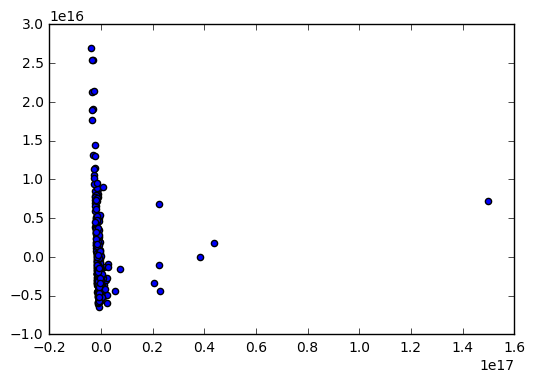

In [51]:
# 6

# PREDICT WINS
# We attempt PCA to reduce the high-dimensionality of the features even further
# Then, we attempt KNN 
payment_x = p.read_csv('payment_x.csv')
teamWins = p.read_csv('teamWins.csv')
teamWins.drop(teamWins.columns[0], axis=1, inplace=True)
years = teamWins.values.tolist()
payment_y = [item for sublist in years for item in sublist]
payment_y = np.array(payment_y)
payment_y = (payment_y - 40) / 5

payment_x[payment_x.columns[0]] = payment_x[payment_x.columns[0]]**2
payment_x[payment_x.columns[1]] = payment_x[payment_x.columns[1]]**2

payment_train_x, payment_test_x, payment_train_y, payment_test_y = train_test_split(payment_x, payment_y, test_size=0.3, random_state=0)

# PCA 
from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=2)
train_transformed = pca.fit_transform(payment_train_x)
plt.scatter(train_transformed[:,0:1], train_transformed[:,1:2])
test_transformed = pca.fit_transform(payment_test_x)

# KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_transformed, payment_train_y)
predictions = neigh.predict(test_transformed)

# LR
wins_regr = linear_model.LinearRegression()
scores = cross_val_score(wins_regr, train_transformed, payment_train_y, cv=5)
wins_regr.fit(train_transformed, payment_train_y)
predictions = wins_regr.predict(test_transformed)

In [50]:
# 7

# Now, predict wins based off of standard features
payment_x = p.read_csv('FullTwenty.csv')
teamWins = p.read_csv('teamWins.csv')
teamWins.drop(teamWins.columns[0], axis=1, inplace=True)
years = teamWins.values.tolist()
payment_y = [item for sublist in years for item in sublist]

# Remove outlier win totals
outliers = []
for idx, num in enumerate(payment_y):
    if num > 96 or num < 50:
        outliers.append(idx)
payment_y = [payment_y[i] for j, i in enumerate(payment_y) if j not in outliers]
payment_x.drop(payment_x.index[outliers], inplace=True)
payment_train_x, payment_test_x, payment_train_y, payment_test_y = train_test_split(payment_x, payment_y, test_size=0.4, random_state=0)

wins_regr = linear_model.LinearRegression()
scores = cross_val_score(wins_regr, payment_train_x, payment_train_y, cv=5)
wins_regr.fit(payment_train_x, payment_train_y)
predictions = wins_regr.predict(payment_test_x)